In [412]:
# Import dependencies 
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from prophet import Prophet
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split


In [413]:
# Load the news_articles.csv into a DataFrame.
stock_data_df = pd.read_csv('Resources/stock_yfinance_data.csv')
tweet_data_df = pd.read_csv('Resources/stock_tweets.csv')

### Prepare Stock Data

In [414]:
# Display the stock data
stock_data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [415]:
# Assess the data types of the DataFrame
stock_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        6300 non-null   object 
 1   Open        6300 non-null   float64
 2   High        6300 non-null   float64
 3   Low         6300 non-null   float64
 4   Close       6300 non-null   float64
 5   Adj Close   6300 non-null   float64
 6   Volume      6300 non-null   int64  
 7   Stock Name  6300 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 393.9+ KB


In [416]:
# Display the stock data 
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Filter DataFrame to only include specified stocks
filtered_stock_data_df = stock_data_df[stock_data_df['Stock Name'].isin(stock_names_of_interest)]

# Check for NaN and blank values in the DataFrame
blank_or_na_count = filtered_stock_data_df.map(lambda x: pd.isna(x) or x == '').sum()

# Display the count of NaN and blank values for each column
print(blank_or_na_count)

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Stock Name    0
dtype: int64


### Prepare Tweet Data

In [417]:
# Display the tweet data
tweet_data_df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [418]:
# Assess the data types of the DataFrame
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [419]:
# Convert the 'Date' column to a datetime object
tweet_data_df['Date'] = pd.to_datetime(tweet_data_df['Date'])
tweet_data_df['Date'] = tweet_data_df['Date'].dt.date

# Filter the DataFrame to only include the specified stocks
tweets_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']
filtered_tweet_data_df = tweet_data_df[tweet_data_df['Stock Name'].isin(tweets_of_interest)]
filtered_tweet_data_df = filtered_tweet_data_df[['Date', 'Stock Name', 'Tweet']]

filtered_tweet_data_df

,Date,Stock Name,Tweet
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...


In [420]:
# Check for NaN and blank values in the DataFrame
tweet_blank_or_na_count = filtered_tweet_data_df.map(lambda x: pd.isna(x) or x == '').sum()

# Display the count of NaN and blank values for each column
print(tweet_blank_or_na_count)

Date          0
Stock Name    0
Tweet         0
dtype: int64


### Implement VADER Sentiment Analyzer on the Tweet data

In [421]:
# Initialize the VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = filtered_tweet_data_df["Tweet"]

# Function to analyze sentiment of each sentence
def analyze_sentiment(sentences):
    return analyzer.polarity_scores(sentences)

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis to each tweet and create new columns
filtered_tweet_data_df[['Neg', 'Neu', 'Pos', 'Compound']] = filtered_tweet_data_df['Tweet'].apply(lambda x: pd.Series(analyze_sentiment(x)))
filtered_tweet_data_df['Sentiment'] = filtered_tweet_data_df['Compound'].apply(vader_sentiment_label)

filtered_tweet_data_df

,Date,Stock Name,Tweet,Neg,Neu,Pos,Compound,Sentiment
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...,0.125,0.763,0.113,0.0772,Positive
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...,0.000,1.000,0.000,0.0000,Neutral
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...,0.000,0.954,0.046,0.2960,Positive
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0.273,0.590,0.137,-0.7568,Negative
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,...",0.526,0.474,0.000,-0.8750,Negative
...,...,...,...,...,...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...,0.000,0.921,0.079,0.5040,Positive
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...,0.071,0.905,0.024,-0.5106,Negative
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...,0.089,0.821,0.091,-0.2263,Negative
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...,0.000,0.745,0.255,0.9369,Positive


In [422]:
# Group the DataFrame by 'Date' and 'Stock Name' and calculate the mean of the 'Compound' column
mean_score_df = filtered_tweet_data_df.groupby(['Date', 'Stock Name'])['Compound'].mean().reset_index()
mean_score_df.rename(columns={'Compound': 'Mean Compound'}, inplace=True)

mean_score_df

,Date,Stock Name,Mean Compound
0,2021-09-30,AMZN,0.256980
1,2021-09-30,META,0.472467
2,2021-09-30,MSFT,0.256980
3,2021-09-30,PG,0.256980
4,2021-09-30,TSLA,0.251634
...,...,...,...
1763,2022-09-29,AMZN,0.086080
1764,2022-09-29,META,-0.051600
1765,2022-09-29,MSFT,0.086080
1766,2022-09-29,PG,0.086080


In [423]:
# Merge the stock data and mean sentiment score DataFrames
filtered_stock_data_df.loc[:, 'Date'] = pd.to_datetime(filtered_stock_data_df['Date'])
mean_score_df.loc[:, 'Date'] = pd.to_datetime(mean_score_df['Date'])

merged_df = pd.merge(filtered_stock_data_df, mean_score_df, on=['Date', 'Stock Name'], how='inner').reset_index()

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis Label to the 'Mean Compound' column
merged_df['Sentiment'] = merged_df['Mean Compound'].apply(vader_sentiment_label)

merged_df = merged_df[['Date', 'Stock Name', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mean Compound', 'Sentiment']]

merged_df

,Date,Stock Name,Open,High,Low,Close,Adj Close,Volume,Mean Compound,Sentiment
0,2021-09-30 00:00:00,TSLA,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.251634,Positive
1,2021-10-01 00:00:00,TSLA,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.222412,Positive
2,2021-10-04 00:00:00,TSLA,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.151775,Positive
3,2021-10-05 00:00:00,TSLA,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.096692,Positive
4,2021-10-06 00:00:00,TSLA,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.229846,Positive
...,...,...,...,...,...,...,...,...,...,...
1222,2022-09-23 00:00:00,AMZN,116.000000,116.050003,112.059998,113.779999,113.779999,65126700,0.050550,Positive
1223,2022-09-26 00:00:00,AMZN,113.300003,117.339996,113.129997,115.150002,115.150002,62723300,-0.068714,Negative
1224,2022-09-27 00:00:00,AMZN,117.199997,118.320000,113.050003,114.410004,114.410004,60094700,-0.186740,Negative
1225,2022-09-28 00:00:00,AMZN,114.379997,118.699997,113.800003,118.010002,118.010002,55763800,0.418660,Positive


In [424]:
#from sklearn.preprocessing import StandardScaler

# Inpmlement the StandardScaler
#scaler = StandardScaler()

# Select the columns to be scaled
#scaler.fit_transform(merged_df[['Mean Compound', 'Close']])
#merged_df.loc[:, 'Date'] = pd.to_datetime(merged_df['Date']).dt.date
# Fill NaN values in 'Mean Compound' with the mean of the column
#merged_df['Mean Compound'] = merged_df['Mean Compound'].fillna(merged_df['Mean Compound'].mean())

# Stadardized DataFrame
#print(merged_df.head())

In [425]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# List of stock names to iterate over
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Rename 'Date' to 'ds' and 'Close' to 'y' to be compatible with Prophet
df = merged_df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Convert 'ds' to datetime format if not already in that format
df['ds'] = pd.to_datetime(df['ds'])

# Loop through each stock name
for stock in stock_names_of_interest:
    # Filter the data for the current stock
    stock_data = df[df['Stock Name'] == stock]
    
    # Split data into training and test sets (80% train, 20% test)
    train_size = int(0.8 * len(stock_data))
    train_data = stock_data[:train_size]
    test_data = stock_data[train_size:]
    
    # Initialize the Prophet model
    model = Prophet()
    model.add_regressor('Mean Compound')
    
    # Train the model
    model.fit(train_data[['ds', 'y', 'Mean Compound']])
    
    # Make future dataframe (for prediction up to the end of the test data)
    future = model.make_future_dataframe(periods=len(test_data), freq='D')
    future = future.merge(stock_data[['ds', 'Mean Compound']], on='ds', how='left')
    
    # Fill any NaN values in 'Mean Compound'
    future['Mean Compound'] = future['Mean Compound'].fillna(0)
    
    # Predict using the Prophet model
    forecast = model.predict(future)
    
    # Calculate performance metrics (compare actual y values from test set to predictions)
    y_true = test_data['y'].values  # Actual values
    y_pred = forecast['yhat'][-len(test_data):].values  # Predicted values
    
    # Compute performance metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Display performance report
    print(f"Performance Report for {stock}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")


16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for TSLA:
Mean Absolute Error (MAE): 97.1478
Mean Squared Error (MSE): 10390.8842
Root Mean Squared Error (RMSE): 101.9357
R-squared (R²): -50.7652


16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for MSFT:
Mean Absolute Error (MAE): 20.6780
Mean Squared Error (MSE): 638.0486
Root Mean Squared Error (RMSE): 25.2596
R-squared (R²): -1.1076


16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for PG:
Mean Absolute Error (MAE): 7.3421
Mean Squared Error (MSE): 67.4683
Root Mean Squared Error (RMSE): 8.2139
R-squared (R²): -1.6513


16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for META:
Mean Absolute Error (MAE): 21.2960
Mean Squared Error (MSE): 621.0786
Root Mean Squared Error (RMSE): 24.9214
R-squared (R²): -4.5065
Performance Report for AMZN:
Mean Absolute Error (MAE): 41.0976
Mean Squared Error (MSE): 1765.6265
Root Mean Squared Error (RMSE): 42.0194
R-squared (R²): -20.8468


In [426]:
# Sort the data by 'ds' (date) to ensure the rolling window works correctly
df = df.sort_values('ds')

# Calculate the 60-day rolling average based on the 'y' column (Close price)
df['60_day_moving_avg'] = df['y'].rolling(window=60).mean()

# Display the updated DataFrame to check the new column
print(df[['ds', 'y', '60_day_moving_avg']].tail())


             ds           y  60_day_moving_avg
503  2022-09-29  237.500000         194.033334
251  2022-09-29  268.209991         193.429833
755  2022-09-29  128.699997         191.130667
974  2022-09-29  136.410004         191.052500
1226 2022-09-29  114.800003         190.691667


In [427]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Mapping the sentiment labels to numerical values
merged_df['Sentiment'] = merged_df['Sentiment'].map({
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
})

# List of stock names to iterate over
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']


# Rename 'Date' to 'ds' and 'Close' to 'y' to be compatible with Prophet
df = merged_df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Sort the data by 'ds' (date) to ensure the rolling window works correctly
df = df.sort_values('ds')

# Calculate the 60-day rolling average based on the 'y' column (Close price)
df['60_day_moving_avg'] = df['y'].rolling(window=60).mean()
df['60_day_moving_avg'] = df['60_day_moving_avg'].fillna(0)

# Convert 'ds' to datetime format if not already in that format
df['ds'] = pd.to_datetime(df['ds'])

# Loop through each stock name
for stock in stock_names_of_interest:
    # Filter the data for the current stock
    stock_data = df[df['Stock Name'] == stock]
    
    # Split data into training and test sets (80% train, 20% test)
    train_size = int(0.8 * len(stock_data))
    train_data = stock_data[:train_size]
    test_data = stock_data[train_size:]
    
    # Initialize the Prophet model
    model = Prophet()
    model.add_regressor('Mean Compound')
    model.add_regressor('Volume')
    model.add_regressor('Sentiment')
    model.add_regressor('60_day_moving_avg')
    
    # Train the model
    model.fit(train_data[['ds', 'y', 'Mean Compound', '60_day_moving_avg', 'Volume', 'Sentiment']])
    
    # Make future dataframe (for prediction up to the end of the test data)
    future = model.make_future_dataframe(periods=len(test_data), freq='D')
    future = future.merge(stock_data[['ds', 'Mean Compound', '60_day_moving_avg', 'Volume', 'Sentiment']], on='ds', how='left')
    
    # Fill any NaN values in 'Mean Compound'
    future['Mean Compound'] = future['Mean Compound'].fillna(0)
    future['Volume'] = future['Volume'].fillna(0)
    future['Sentiment'] = future['Sentiment'].fillna('0')
    future['60_day_moving_avg'] = future['60_day_moving_avg'].fillna('0')
    
    # Predict using the Prophet model
    forecast = model.predict(future)
    
    # Calculate performance metrics (compare actual y values from test set to predictions)
    y_true = test_data['y'].values  # Actual values
    y_pred = forecast['yhat'][-len(test_data):].values  # Predicted values
    
    # Compute performance metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Display performance report
    print(f"Performance Report for {stock}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")


16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing


Performance Report for TSLA:
Mean Absolute Error (MAE): 106.8199
Mean Squared Error (MSE): 15904.1996
Root Mean Squared Error (RMSE): 126.1119
R-squared (R²): -78.2314


16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for MSFT:
Mean Absolute Error (MAE): 27.8080
Mean Squared Error (MSE): 1188.2179
Root Mean Squared Error (RMSE): 34.4705
R-squared (R²): -2.9249


16:24:15 - cmdstanpy - INFO - Chain [1] start processing


Performance Report for PG:
Mean Absolute Error (MAE): 6.1914
Mean Squared Error (MSE): 56.7821
Root Mean Squared Error (RMSE): 7.5354
R-squared (R²): -1.2313


16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing


Performance Report for META:
Mean Absolute Error (MAE): 22.1706
Mean Squared Error (MSE): 622.8347
Root Mean Squared Error (RMSE): 24.9567
R-squared (R²): -4.5221


16:24:16 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for AMZN:
Mean Absolute Error (MAE): 38.3743
Mean Squared Error (MSE): 1576.5430
Root Mean Squared Error (RMSE): 39.7057
R-squared (R²): -18.5072


16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


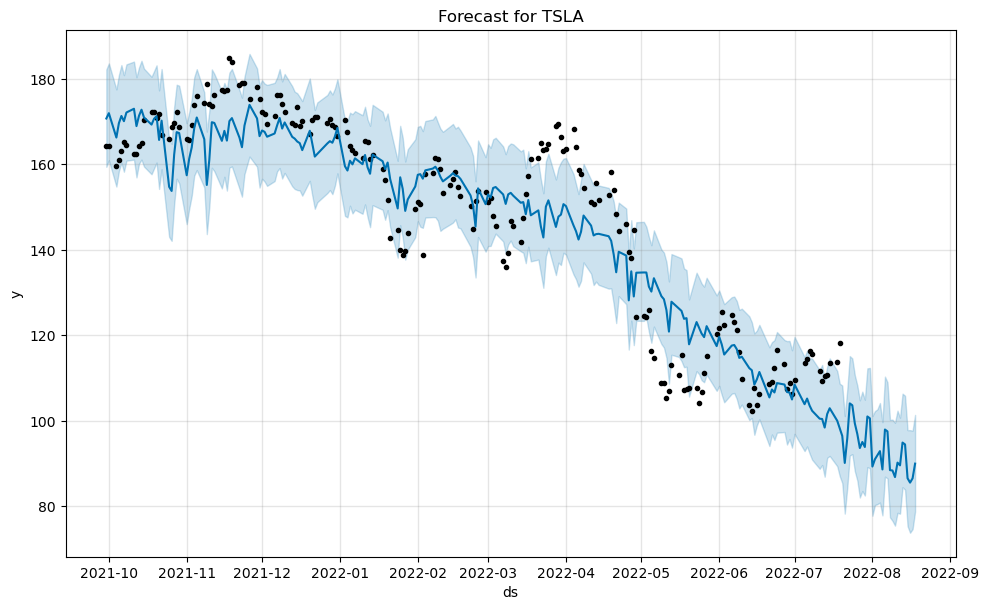

16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


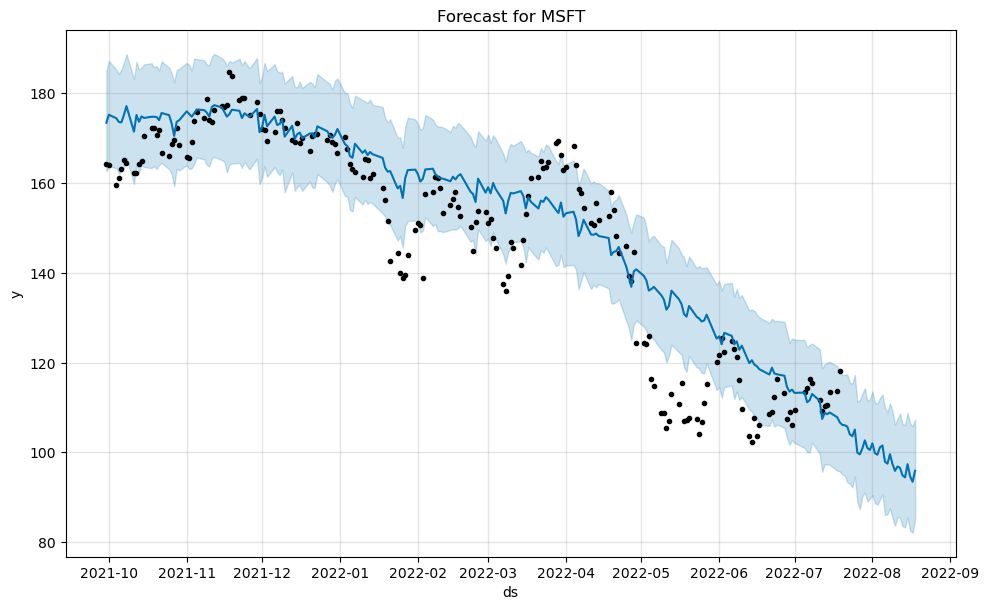

16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


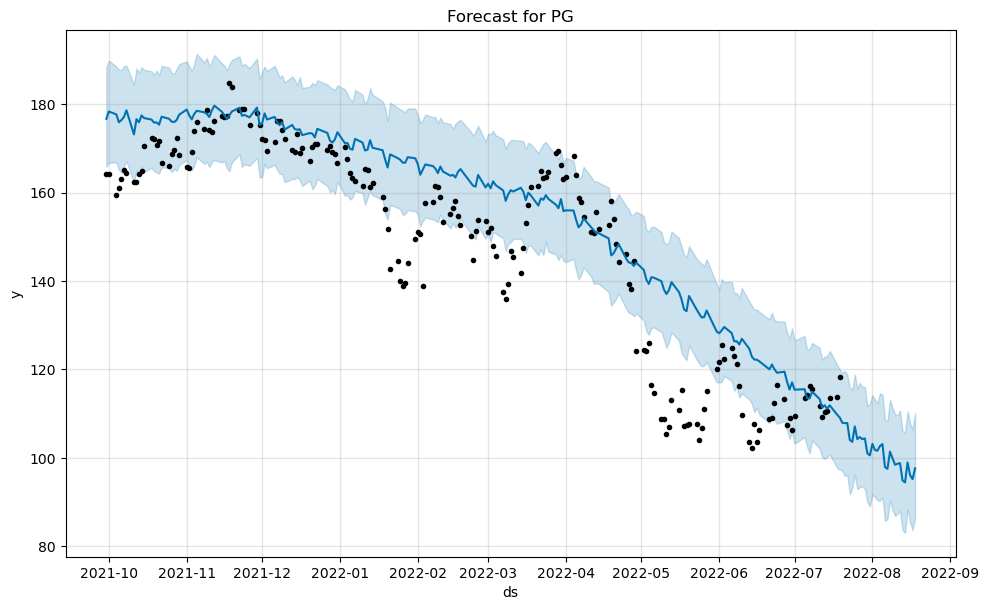

16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


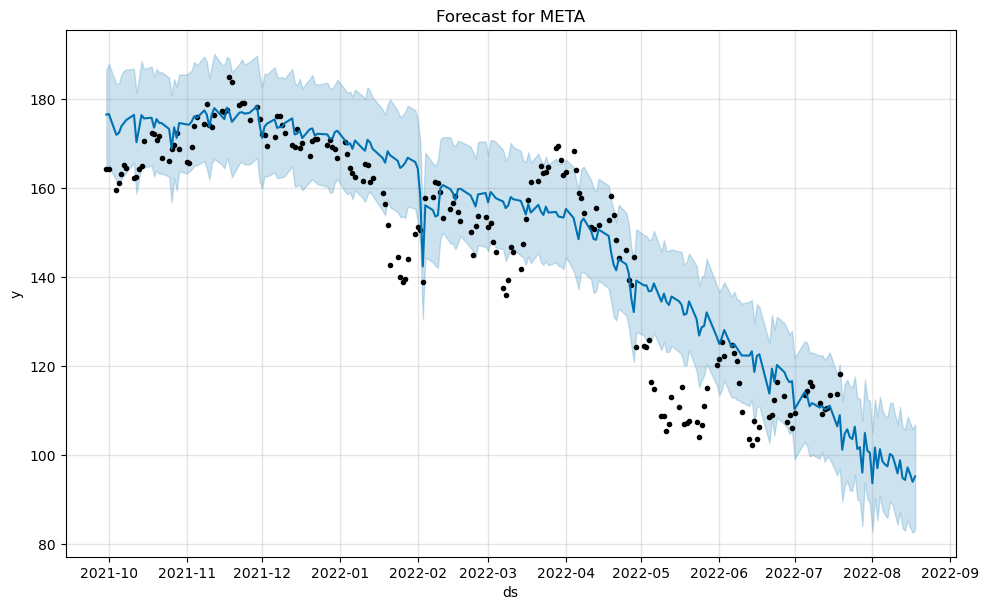

16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


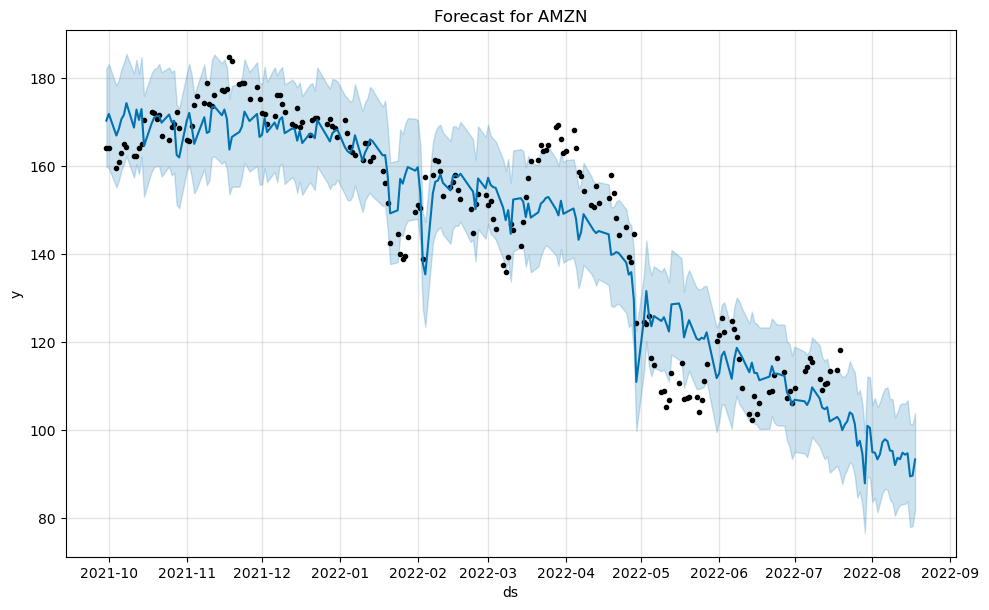

In [428]:
# Mapping the sentiment labels to numerical values
merged_df['Sentiment'] = merged_df['Sentiment'].map({
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
})

# List of stock names to iterate over
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Rename 'Date' to 'ds' and 'Close' to 'y' to be compatible with Prophet
df = merged_df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Convert 'ds' to datetime format if not already in that format
df['ds'] = pd.to_datetime(df['ds'])

# Loop through each stock name
for stock in stock_names_of_interest:
    # Filter the data for the current stock
    stock_data = df[df['Stock Name'] == stock]
    
    # Initialize the Prophet model
    model = Prophet()
    model.add_regressor('Mean Compound')
    model.add_regressor('Volume')
    model.add_regressor('Sentiment')
    
    # Train the model
    model.fit(train_data[['ds', 'y', 'Volume', 'Mean Compound', 'Sentiment']])
    
    # Make future dataframe (predicting for 30 days in the future)
    future = model.make_future_dataframe(periods=30, freq='D')
    
    # Merge the future DataFrame with the regressors for predictions
    future = future.merge(stock_data[['ds', 'Volume', 'Mean Compound', 'Sentiment']], on='ds', how='left')

    # After merging, fill any NaN values
    future['Mean Compound'] = future['Mean Compound'].fillna(0)
    future['Volume'] = future['Volume'].fillna(0)
    future['Sentiment'] = future['Sentiment'].fillna('0')

    # Predict using the Prophet model
    forecast = model.predict(future)
    
    # Plot the forecast
    fig = model.plot(forecast)
    plt.title(f"Forecast for {stock}")
    plt.show()
